In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from labellines import labelLine, labelLines  # will first need to install labellines package
from matplotlib.pyplot import cm
from importlib import reload

import src.utils as utils

seedno = 12345
rng = np.random.default_rng(seed=seedno)

In [2]:
reload(utils)

<module 'src.utils' from '/Users/leandrosb/Documents/GitHub/AMM/src/utils.py'>

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')
# font size for labels in plots
fs = 16
dpi = 300

import pickle

params = { 
    'lambda_sell' : 1., 
    'lambda_buy'  : 1.,
    'kappa' : 1., 
    's' : 100., 
    'depth' : (100*1_000)*1_000,  
    'ymin' : 995, 
    'ymax' : 1005, 
    'y0' : 1000,  
    'T' : 1., 
    'runn' : 0.
    }

with open('src/params.pkl', 'wb') as f: 
    pickle.dump(params, f)

In [4]:
import pickle

with open('src/params.pkl', 'rb') as f:
    params = pickle.load(f)

In [5]:
AMM = utils.AMM(**params)
alpha, beta = AMM.calculate_fees(0.5)

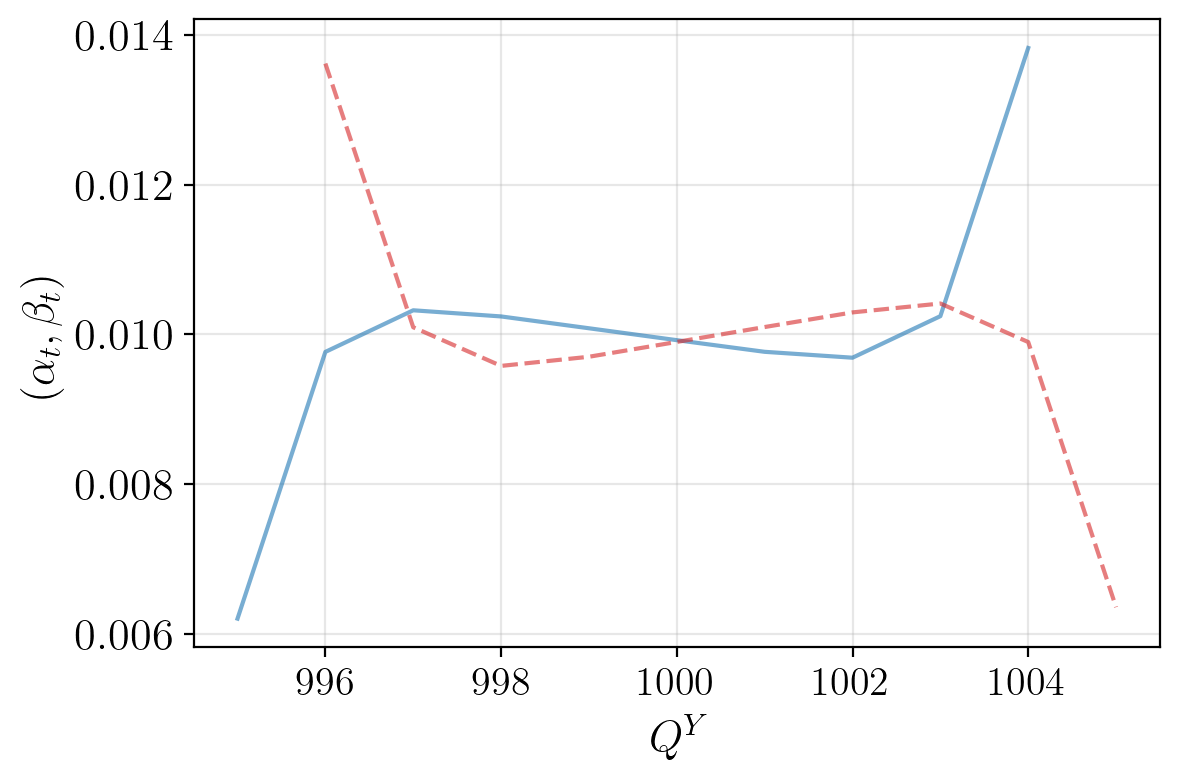

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)

ax.plot(AMM.yvector, alpha[:], '-', color='tab:blue', alpha=0.6)
ax.plot(AMM.yvector, beta[:], '--', color='tab:red', alpha=0.6)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)

plt.tight_layout()
#plt.savefig('figures/approx_opt_depths.pdf', format="pdf", dpi=dpi)
plt.show()

### Implementation

In [7]:
runn_penalty_values = np.zeros(6)
for i in range(0,5):
    runn_penalty_values[i+1] = 10**i

In [8]:
t=0.5
alpha = np.ones((len(AMM.yvector), len(runn_penalty_values)))
beta = np.ones_like(alpha)
for i, runn in enumerate(runn_penalty_values):
    params_aux = params.copy()
    params_aux['runn'] = runn
    AMM_aux = utils.AMM(**params_aux)
    alpha[:,i],beta[:,i] = AMM_aux.calculate_fees(t)

### Plots

In [9]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
#from labellines import labelLines  # Assuming labelLines is imported from somewhere

cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(runn_penalty_values), vmax=max(runn_penalty_values))
sm = ScalarMappable(norm=norm, cmap=cmap)

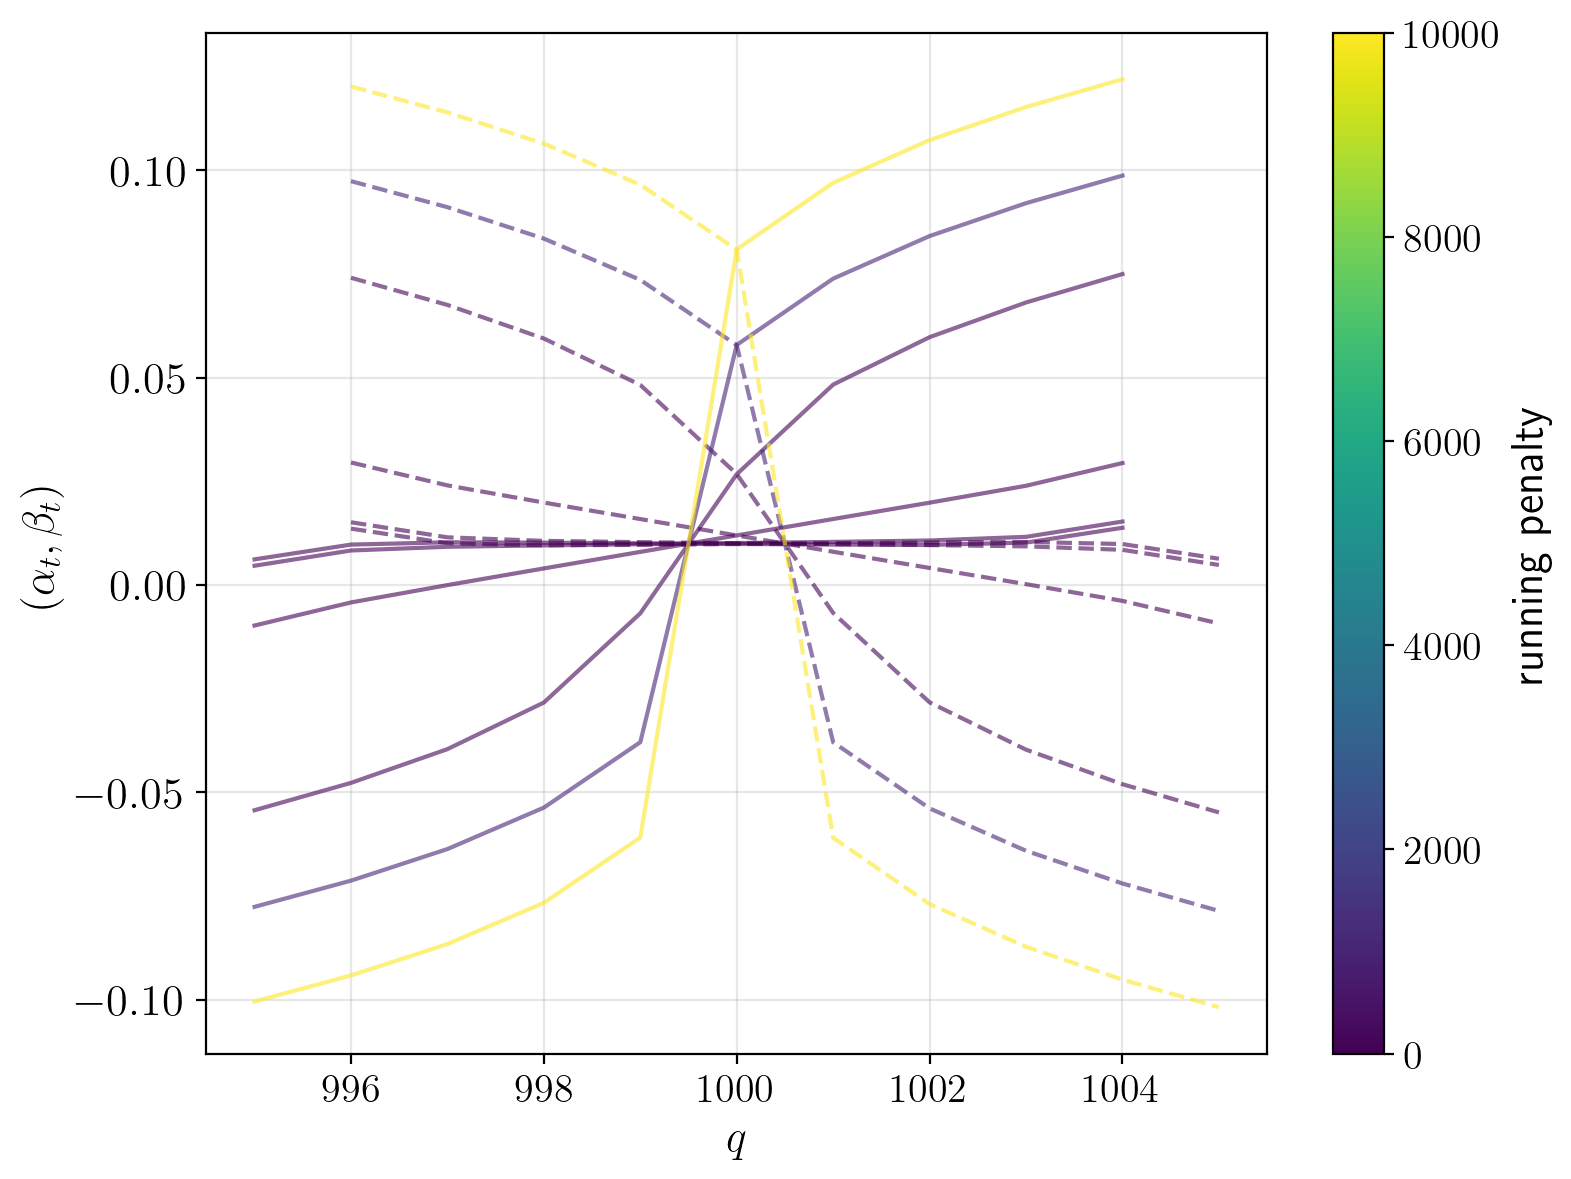

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

for i,q in enumerate(runn_penalty_values):
    color = cmap(norm(runn_penalty_values[i]))
    ax.plot(AMM.yvector, alpha[:,i], '-', color=color, alpha=0.6)
    ax.plot(AMM.yvector, beta[:,i], '--', color=color, alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'$q$', fontsize=fs)
#plt.xticks(range(q_min,q_max +1,2))
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)
#plt.xlim([997,1003])
# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label("running penalty", fontsize=fs)

plt.tight_layout()
plt.savefig('figures/approx_opt_depths.pdf', format="pdf", dpi=dpi)
plt.show()

In [11]:
Nt = 100
t_vector = np.linspace(0, AMM.T,num=Nt)

alpha = np.ones((len(AMM.yvector), len(t_vector)))
beta = np.ones_like(alpha)

for i,t in enumerate(t_vector):
    alpha[:,i],beta[:,i] = AMM.calculate_fees(t)

In [12]:
cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(AMM.yvector), vmax=max(AMM.yvector))
sm = ScalarMappable(norm=norm, cmap=cmap)

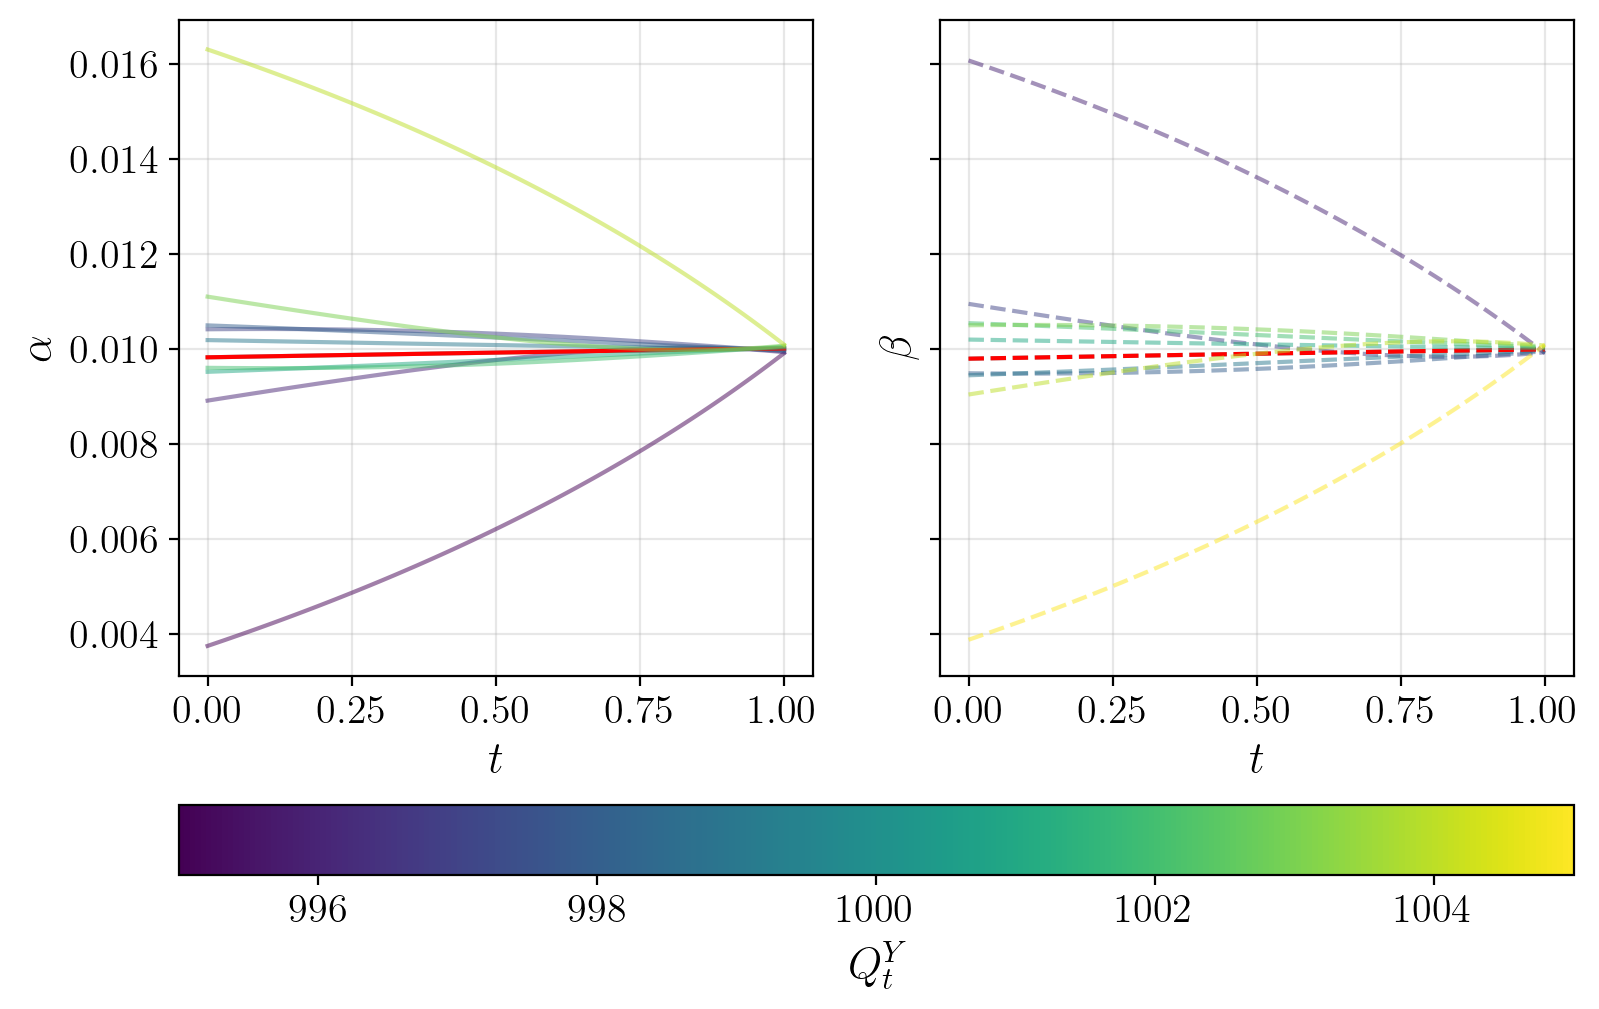

In [13]:
fig, ax = plt.subplots(1,2, figsize = (9,6), sharey=True)
for i,q in enumerate(AMM.yvector):
    color = cmap(norm(AMM.yvector[i]))
    if q < AMM.ymax:
        ax[0].plot(t_vector, alpha[i,:],'-', color = color, alpha = 0.5)#, label="q="+str(q), colors[iq])
    if q == AMM.y0:
        ax[0].plot(t_vector, alpha[i,:],'-', color = "red")#, label="q="+str(q), colors[iq])
    
for i,q in enumerate(AMM.yvector):
    color = cmap(norm(AMM.yvector[i]))
    if q > AMM.ymin:
        ax[1].plot(t_vector, beta[i,:],'--', color = color, alpha = 0.5) #, label="q="+str(q), colors[iq])
    if q == AMM.y0:
        ax[1].plot(t_vector, beta[i,:],'--', color = "red") # label=" ", colors[iq])
        
ax[0].set_xlabel(r'$t$', fontsize = fs)
ax[1].set_xlabel(r'$t$', fontsize = fs)
ax[0].set_ylabel(r'$\alpha$', fontsize = fs)
ax[1].set_ylabel(r'$\beta$', fontsize = fs)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.14)
cbar.set_label(r'$Q^Y_t$', fontsize=fs)

#plt.tight_layout()
plt.savefig('figures/fees_through_time_fct_of_Q_t.pdf', format="pdf", dpi=dpi)
plt.show()

### Studying the case when the boundaries expand

In [14]:
boundary_shift_values = np.array([20, 40, 50, 60, 80, 100])
t = 0.5
y0 = AMM.y0
ymin = AMM.y0 - boundary_shift_values[0]
ymax = AMM.y0 + boundary_shift_values[0]

alpha = np.ones((2*boundary_shift_values[0]+1, len(boundary_shift_values)))
beta = np.ones_like(alpha)

for i, boundary_shift in enumerate(boundary_shift_values):
    params_aux = params.copy()
    params_aux['ymin'] = AMM.y0 - boundary_shift_values[i]
    params_aux['ymax'] = AMM.y0 + boundary_shift_values[i]
    AMM_aux = utils.AMM(**params_aux)
    alpha_aux, beta_aux = AMM_aux.calculate_fees(t)
    if i==0:
        AMM = utils.AMM(**params_aux)
    idx = np.where((AMM_aux.yvector<=ymax)&(AMM_aux.yvector>=ymin))
    alpha[:,i] = alpha_aux[idx].reshape(-1,)
    beta[:,i] = beta_aux[idx].reshape(-1,)

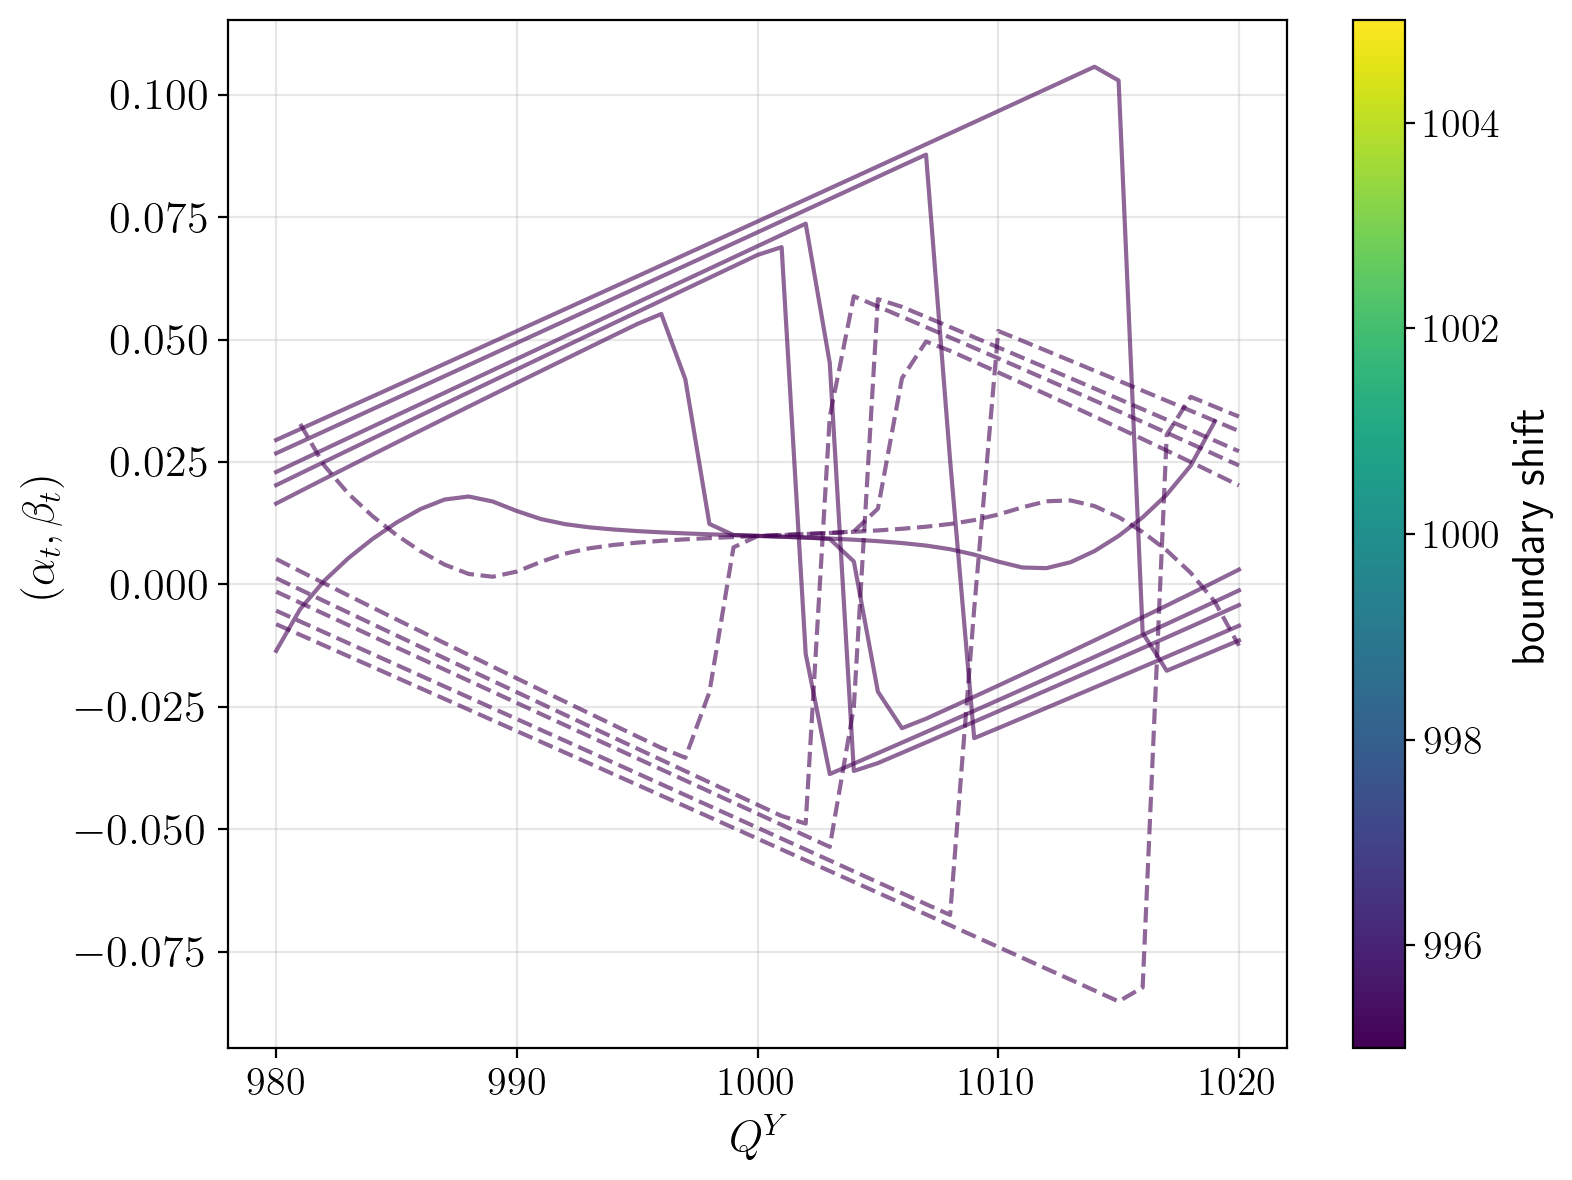

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

#AMM = utils.AMM(**params)
#alpha_base, beta_base = AMM.calculate_fees(0.5)

#ax.plot(AMM.yvector, alpha_base[:], '-', color='tab:blue', alpha=0.6)
#ax.plot(AMM.yvector, beta_base[:], '--', color='tab:red', alpha=0.6)


for i,shift in enumerate(boundary_shift_values):
    color = cmap(norm(boundary_shift_values[i]))
    ax.plot(AMM.yvector, alpha[:,i], '-', color=color, alpha=0.6)
    ax.plot(AMM.yvector, beta[:,i], '--', color=color, alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)
# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label("boundary shift", fontsize=fs)

plt.tight_layout()
#plt.savefig('figures/boundary_shifts.pdf', format="pdf", dpi=dpi)
plt.show()

# Symmetric AMM!

In [21]:
reload(utils)

<module 'src.utils' from '/Users/leandrosb/Documents/GitHub/AMM/src/utils.py'>

In [22]:
shift = 10
y0 = 1_000
delta_z_tilde = 0.01
params = { 
    'lambda_sell' : 1., 
    'lambda_buy'  : 1.,
    'kappa' : 1., 
    'delta_z_tilde' : delta_z_tilde,
    's' : 100., 
    'depth' : (100*y0)*y0,  
    'max_shift' : shift,
    'y0' : y0,
    'T' : 1.,
    'runn' : 0.
    }


AMM = utils.AMM_symmetric(**params)
alpha_check, beta_check = AMM.calculate_fees(0.5)

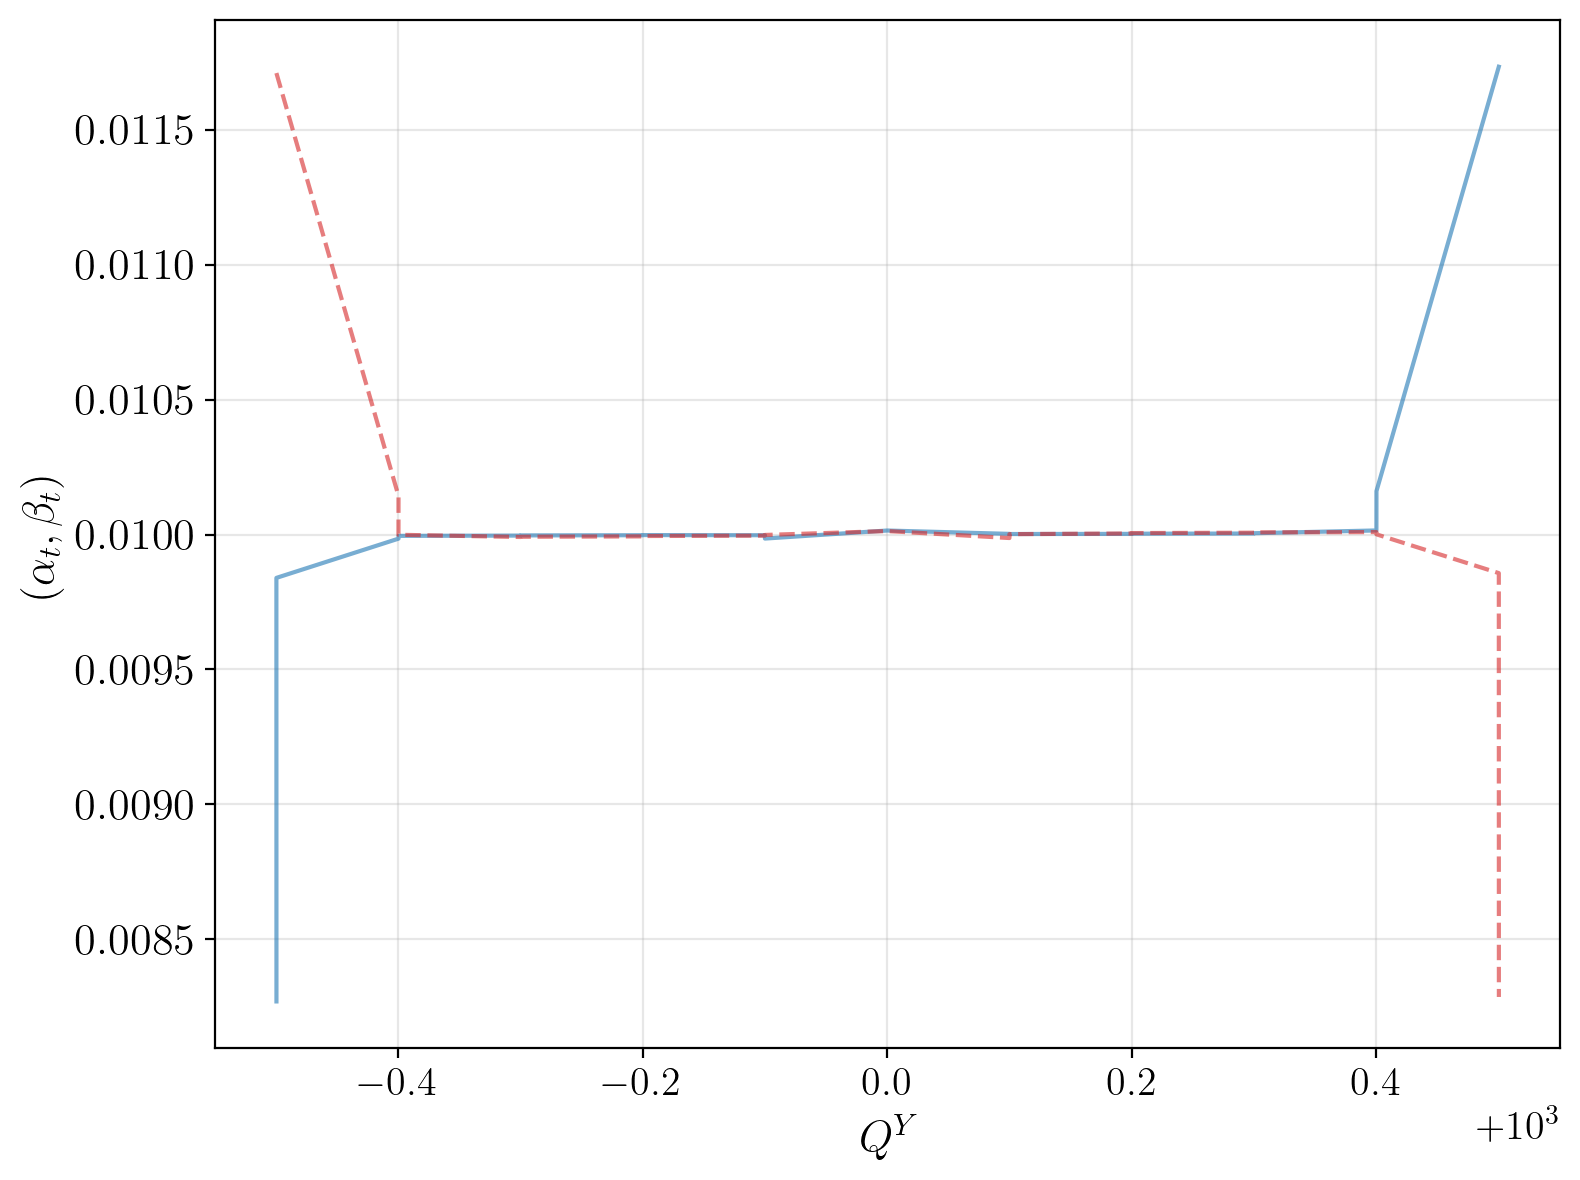

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.yvector, alpha_check[:], '-', color='tab:blue', alpha=0.6)
ax.plot(AMM.yvector, beta_check[:], '--', color='tab:red', alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)
plt.tight_layout()
plt.show()

### Studying the case when the boundaries expand

In [27]:
boundary_shift_values = np.array([20, 40, 50, 60, 80, 100])
t = 0.5
y0 = AMM.y0

alpha = np.ones((2*boundary_shift_values[0]+1, len(boundary_shift_values)))
beta = np.ones_like(alpha)

for i, boundary_shift in enumerate(boundary_shift_values):
    params_aux = params.copy()
    params_aux['max_shift'] = boundary_shift_values[i]
    AMM_aux = utils.AMM_symmetric(**params_aux)
    alpha_aux, beta_aux = AMM_aux.calculate_fees(t)
    if i==0:
        AMM = utils.AMM_symmetric(**params_aux)
        ymax = AMM.yvector[-1]
        ymin = AMM.yvector[0]
    idx = np.where((AMM_aux.yvector<=ymax+1e-3)&(AMM_aux.yvector>=ymin-1e-3))
    alpha[:,i] = alpha_aux[idx].reshape(-1,)
    beta[:,i] = beta_aux[idx].reshape(-1,)

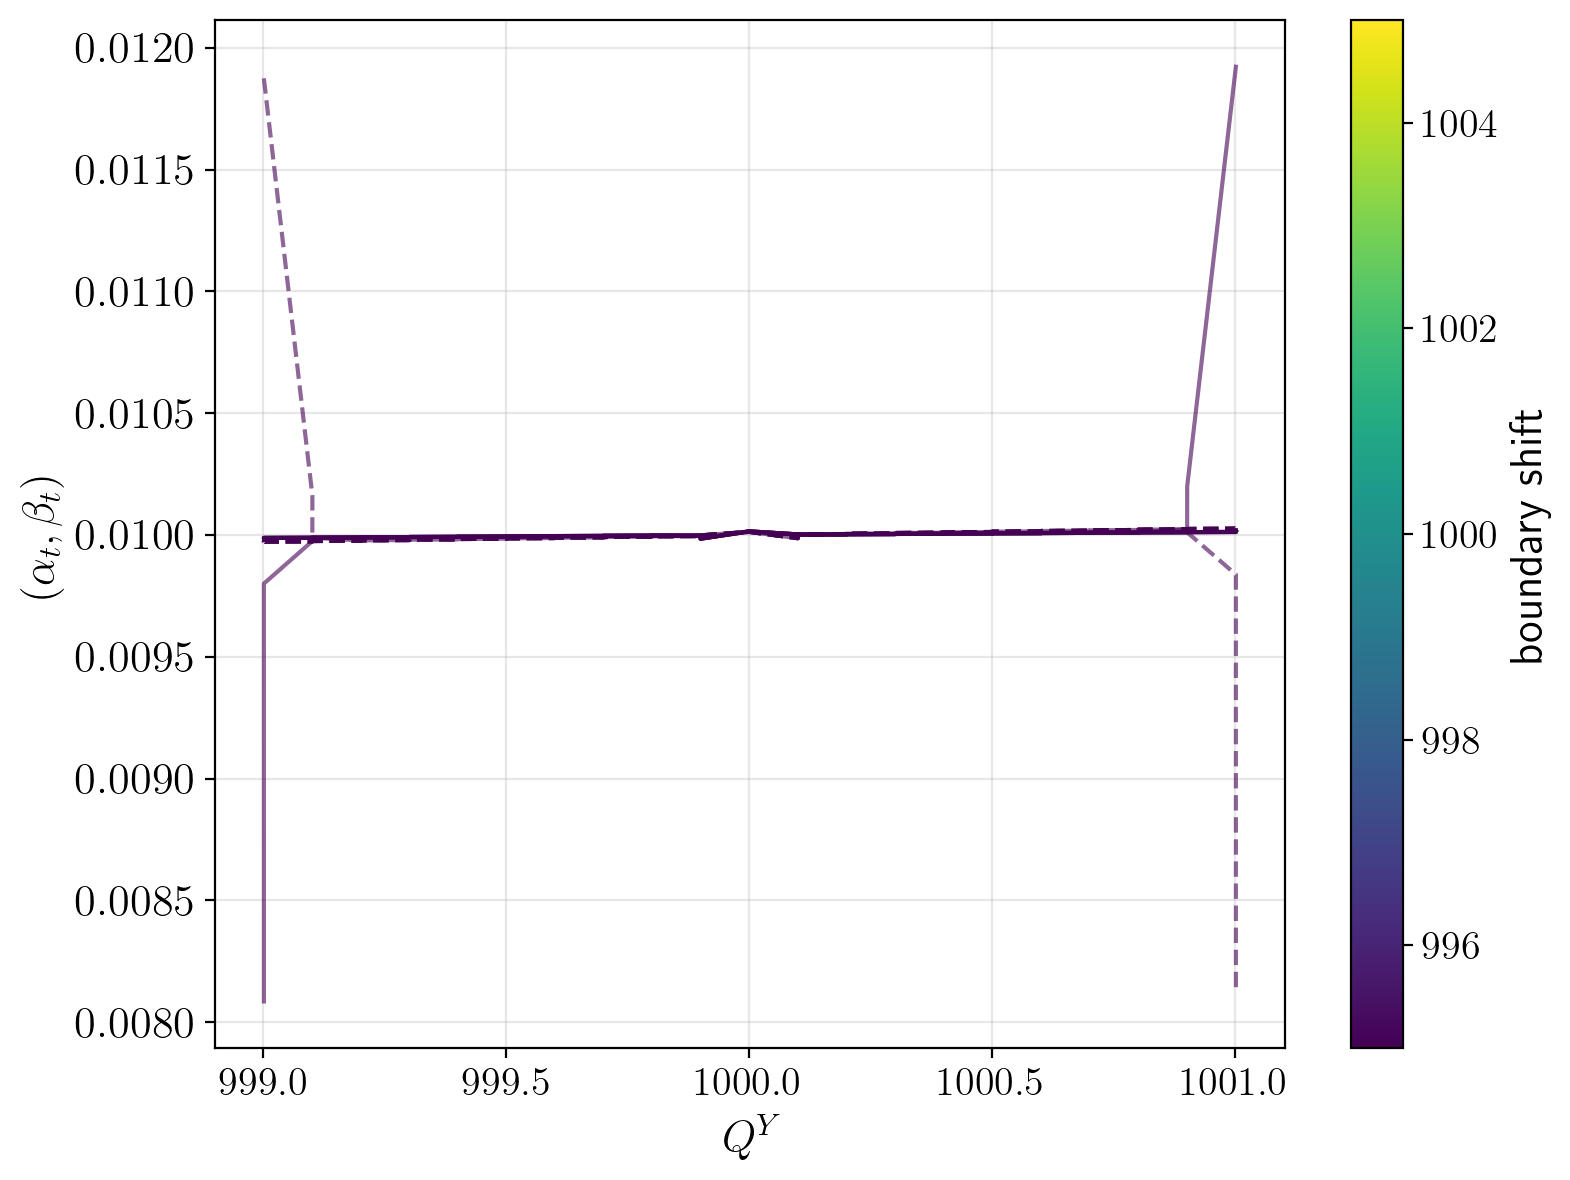

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

#AMM = utils.AMM(**params)
#alpha_base, beta_base = AMM.calculate_fees(0.5)

#ax.plot(AMM.yvector, alpha_base[:], '-', color='tab:blue', alpha=0.6)
#ax.plot(AMM.yvector, beta_base[:], '--', color='tab:red', alpha=0.6)


for i,shift in enumerate(boundary_shift_values):
    color = cmap(norm(boundary_shift_values[i]))
    ax.plot(AMM.yvector, alpha[:,i], '-', color=color, alpha=0.6)
    ax.plot(AMM.yvector, beta[:,i], '--', color=color, alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
#plt.ylim([0.0095,0.0105])
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)
# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label("boundary shift", fontsize=fs)

plt.tight_layout()
#plt.savefig('figures/boundary_shifts.pdf', format="pdf", dpi=dpi)
plt.show()